# A First Look to Forecast with Prophet

The main **core** of this notebook is to get a general introduction to the [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) module.

I am going to use these [Dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) which stores Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

Variables are:
- holiday:     | Categorical | variable for the US National holiday plus regional holiday, Minnesota State Fair.
- temp:        | Continuous  | Average temp in Kelvin.
- rain_1h      | Continuous  | Amount in mm of rain that occurred in the hour.
- snow_1h      | Continuous  | Amount in mm of snow that occurred in the hour.
- clouds_all   | Integer     | Percentage of cloud cover.
- weather_main | Categorical | Short textual description of the current weather.
- weather_description | Categorical | Longer textual description of the current weather
- date_time | Date  | Hour of the data collected in local CST time.
- traffic_volume | integer | Hourly I-94 ATR 301 reported westbound traffic volume

In [32]:
# Modules
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
  # fetch dataset 
metro_interstate_traffic_volume = fetch_ucirepo(id=492) 
  
# data (as pandas dataframes) 
X = metro_interstate_traffic_volume.data.features 
y = metro_interstate_traffic_volume.data.targets 

# Concat dataframes
df = pd.concat([X,y], axis = 1)
# Cast Datetime 

df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.strftime('%Y-%m-%d')

In [4]:
print(f'Shape of the DataFrame: {df.shape}')

Shape of the DataFrame: (48204, 10)


In [37]:
def metrics(x, nbr = 0):

    mean = np.round(np.mean(x), nbr)
    min = np.min(x)
    max = np.max(x)

    string_ = f'Mean: {mean} | Min: {min} | Max: {max}'
    
    return string_ 


## Prepare Data for Prophet

Prophet needs (essensially) two columns:
- ds: Date column
- y: Target variable

First date in the dataset: 2012-10-02
First date in the dataset: 2018-09-30
Shape:(1860, 2)


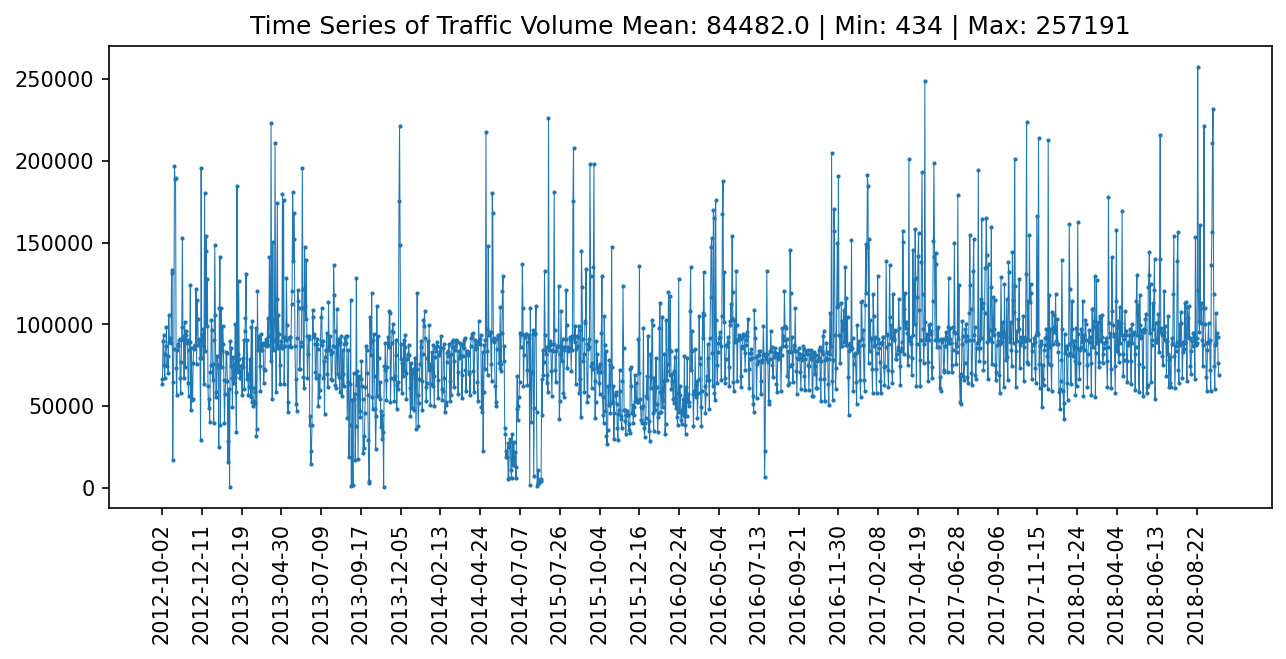

In [39]:
# I am going to group the data in order to have the structure that I need.
t = df.groupby(['date'], as_index = False).agg({'traffic_volume': 'sum'}).rename({'date':'ds', 'traffic_volume' : 'y'}, axis = 1)

# Important things in the dataframe
min_date = t['ds'].min()
print(f'First date in the dataset: {min_date}')

max_date = t['ds'].max()
print(f'First date in the dataset: {max_date}')

# Shape of the dataFrame
print(f'Shape:{t.shape}')

add_name = metrics(t['y'].values)


# Plot
fig, ax = plt.subplots(dpi = 150, figsize = (10,4))
plt.title(f'Time Series of Traffic Volume {add_name}')
plt.plot(t['ds'], t['y'], linewidth = 0.5, marker = 'o', markersize = 1)
xticks = t['ds'][::70] 
plt.xticks(xticks, rotation=90)
plt.show()

When visualizing the data, it is observed that the amount of traffic can be a candidate to be forecasted with a time series model.